In this notebook, I will present my analysis of the Credit Card Fraud Detection dataset from Kaggle. The data set can be found at https://www.kaggle.com/dalpozz/creditcardfraud

In [1]:
# Import necessary modules

import numpy as np
import pandas as pd
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data=pd.read_csv('creditcard.csv')# Load the data

In [4]:
data.head()# Inspect the data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


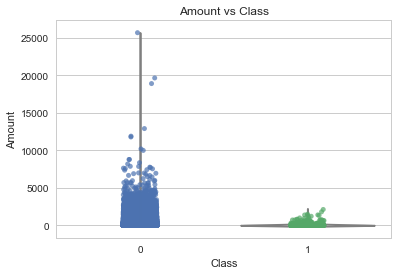

In [5]:
%matplotlib inline
sns.set_style('whitegrid')
fig=plt.figure()
sns.violinplot(x='Class',y='Amount',data=data,inner=None,color='lightgray')
sns.stripplot(x='Class',y='Amount',data=data,jitter=True,alpha=0.7)
plt.title('Amount vs Class')
plt.show()
plt.gcf().clear()

From above visualization, we can see the given data set is highly unbalanced. Only a small portion of given transaction instances is labeld fradulent. To handle an unbalanced calssification task like this. I will present two well used methods down below.

Firstly, an Algorithmic approach is to use ensemble methods such as boosting, which combine multiple learners by sequentially correcting the mistakes made by previous learners. But before we fit any models, let's first do some preprocessing.

In [6]:
data_2=data.drop('Class',axis=1)

In [7]:
labels=data['Class']

In [8]:
# Scale all continuous features to the range of (0,1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
data_2=scaler.fit_transform(data_2)

In [9]:
# Train-Test-Split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data_2,labels,
                                               test_size=0.2,
                                            stratify=labels)

In [10]:
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


In [11]:
# Number of Frauds in training data

num_fraud_train=sum(y_train==1)
num_nonfraud_train=sum(y_train==0)

print('Percent of fraud: {:.4f}'.format(float(num_fraud_train/y_train.shape[0])))

Percent of fraud: 0.0017


In [12]:
# Number of Frauds in test data


num_fraud_test=sum(y_test==1)
num_nonfraud_test=sum(y_test==0)

print('Percent of fraud: {:.4f}'.format(float(num_fraud_test/y_test.shape[0])))

Percent of fraud: 0.0017


### Light GBM

In [13]:
# LightGBM Model as a benchmark

params={'task':'train','objective':'binary','boosting':'dart',
        'learning_rate':0.1 ,'num_leaves':40,'is_unbalance':True,
        'tree_learner':'serial', 'max_depth':-1,'min_data_in_leaf':20,
        'min_sum_hessian_in_leaf':1e-3,'feature_fraction':0.8,
        'bagging_fraction':0.8,'bagging_freq':30,'max_bin':255
    }

In [14]:
d_train=lgb.Dataset(x_train,label=y_train)

In [15]:
ROUNDS=100
bst=lgb.train(params,d_train,ROUNDS)

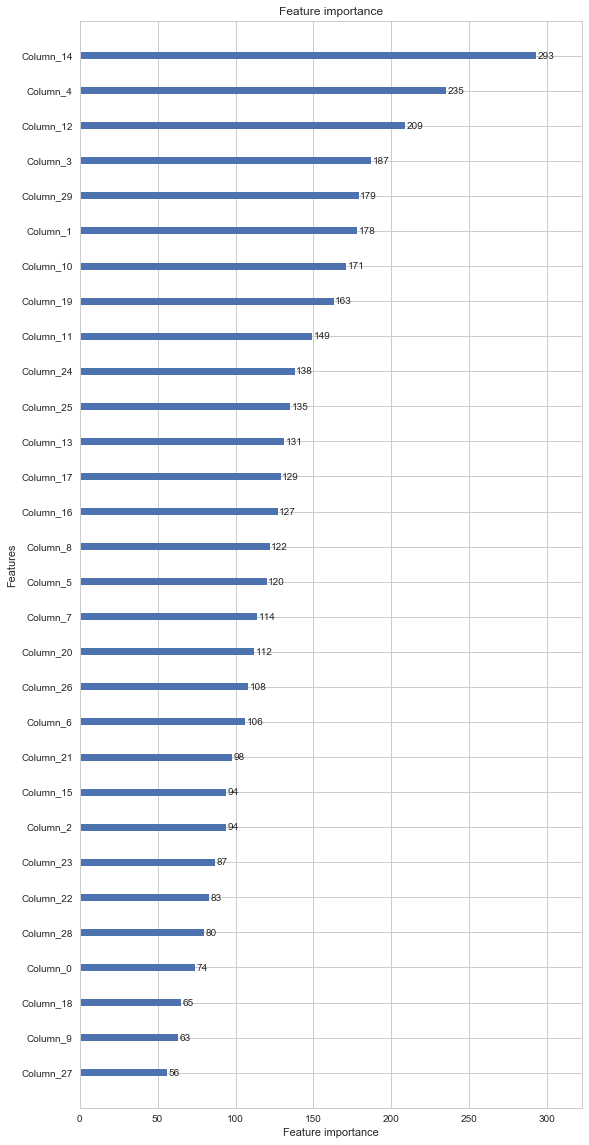

In [16]:
# Feature importance plot

lgb.plot_importance(bst,figsize=(9,20))

In [17]:
preds=bst.predict(x_test)

In [18]:
# correction rate
sum((preds>0.5)==y_test)/y_test.shape[0]

0.99919244408553065

In [28]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,_=roc_curve(np.array(y_test),preds)

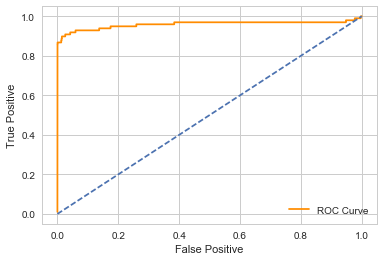

In [29]:
# Plot the ROC curve

fig=plt.figure()
plt.plot(fpr,tpr,color='darkorange',label='ROC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend(loc='lower right')
plt.show()
plt.gcf().clear()

In [30]:
Auc=auc(fpr,tpr)
print('AUC score: {:4f}'.format(Auc))

AUC score: 0.958651


In [31]:
fraud_cases=[]
for index,l in enumerate(y_test.values):
    if l==1:
        fraud_cases.append(index)  

In [32]:
x_test_fraud=x_test[fraud_cases,:]
y_test_fraud=y_test.values[fraud_cases]

In [33]:
# True positive rate
preds=bst.predict(x_test_fraud)
sum((preds>0.5)==y_test_fraud)/y_test_fraud.shape[0]

0.86734693877551017

In [56]:
y_test=np.array(y_test)
y_test=y_test.reshape(-1,1)

### Feed Forward Neural Networks Using Tensorflow

Second approach is to modify the loss function. We can assign a bigger weight towards cases in minority class while calculating the loss, which essentially forces our model to pay more attention towards those minority cases. I will demonstrate this approach with a neural network.

In [34]:
import tensorflow as tf ## Load tnesorflow

In [36]:
tf.reset_default_graph()

In [52]:
# generator function to help fetch data batch by batch
def get_batches(x,y,bacth_size):
    y=np.array(y)
    num_batches=x.shape[0]//batch_size
    x_batch=x[:num_batches*batch_size,:]
    y_batch=y[:num_batches*batch_size]
    for i in range(num_batches):
        batch_x=x_batch[i:i+batch_size,:]
        batch_y=y_batch[i:i+batch_size]
        batch_y=batch_y.reshape(-1,1)
        class_weight=1/(np.sum(batch_y==1)/batch_y.shape[0])    
    yield batch_x,batch_y,class_weight

In [67]:
# Build the computational graph
graph1=tf.Graph()

with graph1.as_default():
    
    x=tf.placeholder(tf.float32,[None,30],name='input')
    y=tf.placeholder(tf.float32,[None,1],name='labels')
    class_weights=tf.placeholder(tf.float32)
    drop_rate=tf.placeholder(tf.float32)
    training=tf.placeholder(tf.bool)
    lr=tf.placeholder(tf.float32)
    initializer= tf.contrib.layers.variance_scaling_initializer()# Using He initializer for weight initialization
    
    
    with tf.variable_scope('fully_1'):
        x1=tf.layers.dense(x,128,kernel_initializer=initializer)
        x1=tf.nn.elu(x1)
        x1=tf.layers.dropout(x1,rate=drop_rate,training=training)## Apply dropout to regularize our network
        
    with tf.variable_scope('fully_2'):
        x2=tf.layers.dense(x1,256,kernel_initializer=initializer)
        x2=tf.nn.elu(x2)
        x2=tf.layers.dropout(x2,rate=drop_rate,training=training)
    
    
    with tf.variable_scope('fully_3'):
        x3=tf.layers.dense(x2,512,kernel_initializer=initializer)
        x3=tf.nn.elu(x3)
        x3=tf.layers.dropout(x3,rate=drop_rate,training=training)
        
    with tf.variable_scope('output'):
        logits=tf.layers.dense(x3,1,kernel_initializer=initializer)
        Output=tf.nn.sigmoid(logits)
    ###Evalution######################################
    
    with tf.name_scope('Optimizer'):
        ## Since the dataset is highly unbalanced, here I will handle his issue by manually assigning
        ## weights to each instance in the minibatch, i.e. give the cases in minority class a proportionally
        ## higher weigh. We can achieve this by using the tf.nn.weighted_cross_entropy_with_logits. Details
        ## regarding this function can be found at 
        ## https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
        loss=tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(y,logits,class_weights))
        optimizer=tf.train.AdamOptimizer(lr,epsilon=0.1)
        train_op=optimizer.minimize(loss)
        

In [78]:
# Train and test the network

# Hyper parameters
save_dir='./checkpoints'
n_epoch=500
batch_size=20000
learning_rate=0.0008
droprate=0.2

with tf.Session(graph=graph1) as sess:
    
    sess.run(tf.global_variables_initializer())
    saver=tf.train.Saver(max_to_keep=1)
    for epoch in range(n_epoch):
        for batch_x,batch_y,class_weight in get_batches(x_train,y_train,batch_size):
            sess.run(train_op,feed_dict={x:batch_x,
                                         y:batch_y,
                                         class_weights:class_weight,
                                         training:True,
                                         lr:learning_rate,
                                         drop_rate:droprate})
            train_loss=sess.run(loss,{x:batch_x,y:batch_y,class_weights:class_weight,training:True,
                           lr:learning_rate,drop_rate:droprate})
        probs=sess.run(Output,{x:x_test,y:y_test,training:False,drop_rate:droprate})
        fpr,tpr,_=roc_curve(y_test,probs)
        auc_score=auc(fpr,tpr)
        print('Epoch: {} '.format(epoch),'Train_loss: {:4f} '.format(train_loss),'Test AUC Score: {:4f}'.format(auc_score))
            
    
    saver.save(sess,save_dir)# save the model
    
            


Epoch: 0  Train_loss: 1.677960  Test AUC Score: 0.746202
Epoch: 1  Train_loss: 1.464788  Test AUC Score: 0.752335
Epoch: 2  Train_loss: 1.685808  Test AUC Score: 0.759722
Epoch: 3  Train_loss: 1.486562  Test AUC Score: 0.767614
Epoch: 4  Train_loss: 1.453003  Test AUC Score: 0.776065
Epoch: 5  Train_loss: 1.682655  Test AUC Score: 0.785206
Epoch: 6  Train_loss: 1.514924  Test AUC Score: 0.794530
Epoch: 7  Train_loss: 1.501305  Test AUC Score: 0.804091
Epoch: 8  Train_loss: 1.499618  Test AUC Score: 0.813422
Epoch: 9  Train_loss: 1.554272  Test AUC Score: 0.822800
Epoch: 10  Train_loss: 1.440997  Test AUC Score: 0.831919
Epoch: 11  Train_loss: 1.659788  Test AUC Score: 0.840537
Epoch: 12  Train_loss: 1.667895  Test AUC Score: 0.848790
Epoch: 13  Train_loss: 1.647949  Test AUC Score: 0.857039
Epoch: 14  Train_loss: 1.528591  Test AUC Score: 0.864948
Epoch: 15  Train_loss: 1.598614  Test AUC Score: 0.872369
Epoch: 16  Train_loss: 1.377520  Test AUC Score: 0.879544
Epoch: 17  Train_loss: 1

Epoch: 141  Train_loss: 0.992995  Test AUC Score: 0.979088
Epoch: 142  Train_loss: 0.944616  Test AUC Score: 0.979080
Epoch: 143  Train_loss: 1.037876  Test AUC Score: 0.979053
Epoch: 144  Train_loss: 0.972428  Test AUC Score: 0.979024
Epoch: 145  Train_loss: 1.099186  Test AUC Score: 0.979013
Epoch: 146  Train_loss: 1.099221  Test AUC Score: 0.978998
Epoch: 147  Train_loss: 0.909419  Test AUC Score: 0.978999
Epoch: 148  Train_loss: 1.039534  Test AUC Score: 0.978987
Epoch: 149  Train_loss: 1.132710  Test AUC Score: 0.978981
Epoch: 150  Train_loss: 0.943487  Test AUC Score: 0.978966
Epoch: 151  Train_loss: 0.997035  Test AUC Score: 0.978959
Epoch: 152  Train_loss: 1.111413  Test AUC Score: 0.978976
Epoch: 153  Train_loss: 1.043693  Test AUC Score: 0.978976
Epoch: 154  Train_loss: 1.021428  Test AUC Score: 0.978954
Epoch: 155  Train_loss: 1.049094  Test AUC Score: 0.978924
Epoch: 156  Train_loss: 0.955580  Test AUC Score: 0.978909
Epoch: 157  Train_loss: 1.024885  Test AUC Score: 0.9788

Epoch: 282  Train_loss: 0.839128  Test AUC Score: 0.976003
Epoch: 283  Train_loss: 0.869563  Test AUC Score: 0.976006
Epoch: 284  Train_loss: 0.802785  Test AUC Score: 0.976007
Epoch: 285  Train_loss: 0.856766  Test AUC Score: 0.976004
Epoch: 286  Train_loss: 0.818805  Test AUC Score: 0.976000
Epoch: 287  Train_loss: 0.789394  Test AUC Score: 0.976003
Epoch: 288  Train_loss: 0.791831  Test AUC Score: 0.976002
Epoch: 289  Train_loss: 0.953095  Test AUC Score: 0.976002
Epoch: 290  Train_loss: 0.903932  Test AUC Score: 0.975993
Epoch: 291  Train_loss: 0.746510  Test AUC Score: 0.975994
Epoch: 292  Train_loss: 0.927531  Test AUC Score: 0.976003
Epoch: 293  Train_loss: 0.819422  Test AUC Score: 0.976007
Epoch: 294  Train_loss: 0.835126  Test AUC Score: 0.976012
Epoch: 295  Train_loss: 0.785712  Test AUC Score: 0.976007
Epoch: 296  Train_loss: 0.890306  Test AUC Score: 0.976005
Epoch: 297  Train_loss: 0.883628  Test AUC Score: 0.976002
Epoch: 298  Train_loss: 0.901964  Test AUC Score: 0.9759

Epoch: 423  Train_loss: 0.748250  Test AUC Score: 0.975158
Epoch: 424  Train_loss: 0.593480  Test AUC Score: 0.975144
Epoch: 425  Train_loss: 0.679778  Test AUC Score: 0.975127
Epoch: 426  Train_loss: 0.746619  Test AUC Score: 0.975112
Epoch: 427  Train_loss: 0.828180  Test AUC Score: 0.975095
Epoch: 428  Train_loss: 0.738894  Test AUC Score: 0.975088
Epoch: 429  Train_loss: 0.730545  Test AUC Score: 0.975081
Epoch: 430  Train_loss: 0.721879  Test AUC Score: 0.975069
Epoch: 431  Train_loss: 0.749078  Test AUC Score: 0.975071
Epoch: 432  Train_loss: 0.701445  Test AUC Score: 0.975074
Epoch: 433  Train_loss: 0.810724  Test AUC Score: 0.975073
Epoch: 434  Train_loss: 0.681377  Test AUC Score: 0.975076
Epoch: 435  Train_loss: 0.631449  Test AUC Score: 0.975084
Epoch: 436  Train_loss: 0.714049  Test AUC Score: 0.975085
Epoch: 437  Train_loss: 0.656760  Test AUC Score: 0.975077
Epoch: 438  Train_loss: 0.565009  Test AUC Score: 0.975067
Epoch: 439  Train_loss: 0.667043  Test AUC Score: 0.9750

From above results, we can see with a little bit tuning, a 3-hidden layer network can push the AUC score above 0.97 with ease.